# Install & Sitting Packages

In [ ]:
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install numpy==1.16.5
!pip install matplotlib==3.4
!pip install opencv-python==3.4.2.17

TensorFlow 1.x selected.


In [ ]:
print("[DEBUG] Tensorflow")
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

print("[DEBUG] Keras")
import keras
print(keras.__version__)

[DEBUG] Tensorflow
1.15.2
[DEBUG] Keras
2.2.5


Using TensorFlow backend.


## GPU Status

In [1]:
!nvidia-smi

Tue Dec 28 18:16:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.47       Driver Version: 472.47       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| 44%   39C    P8    22W / 150W |    753MiB / 11264MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free:" + humanize.naturalsize(psutil.virtual_memory().available)," |     Proc size:" + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

'ln' 不是內部或外部命令、可執行的程式或批次檔。


  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=9e9970a5b3258f0665ef19b617a010d423017790114c2c1c6d7edbac4f870c73
  Stored in directory: c:\users\gpu\appdata\local\pip\cache\wheels\6e\f8\83\534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


IndexError: list index out of range

## Download PConv Repo from Github

In [ ]:
# !git clone https://github.com/BREND3112317/PConv-Keras pconv

## Init

In [2]:
import os
import gc
from copy import deepcopy
import cv2
import numpy as np

from keras.preprocessing.image import ImageDataGenerator

import matplotlib
import matplotlib.pyplot as plt

os.chdir('./pconv')
from libs.util import random_mask
from libs.pconv_model_bak import PConvUnet
os.chdir('../')

# Settings
MAX_BATCH_SIZE = 128

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load Image

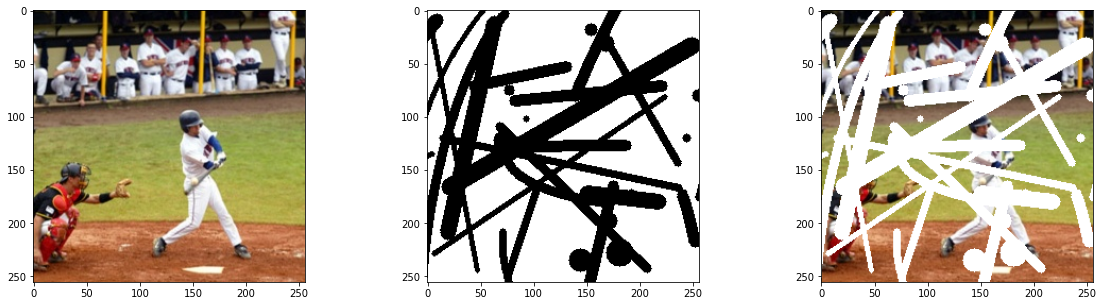

In [3]:
img_path = './pconv/data/dataset/resize_256/image6.jpg'

# Load image
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_cols, image_rows = img.shape[:2]
img = cv2.resize(img, (image_rows, image_cols)) / 255.
shape = img.shape

# Load mask
mask = random_mask(image_cols, image_rows)

# Image + mask
masked_img = deepcopy(img)
masked_img[mask==0] = 1

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(img)
axes[1].imshow(mask*255)
axes[2].imshow(masked_img)
plt.show()

## Model Prepare

In [4]:
weight_filepath = "./pconv/data/model/"

model = PConvUnet(img_rows=image_cols, img_cols=image_rows, weight_filepath=weight_filepath)
model.summary()










Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
p_conv2d_1 (PConv2D)            [(None, 128, 128, 64 9472        input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 64) 0           p_conv2d_1[0][0]  

## Mask Design

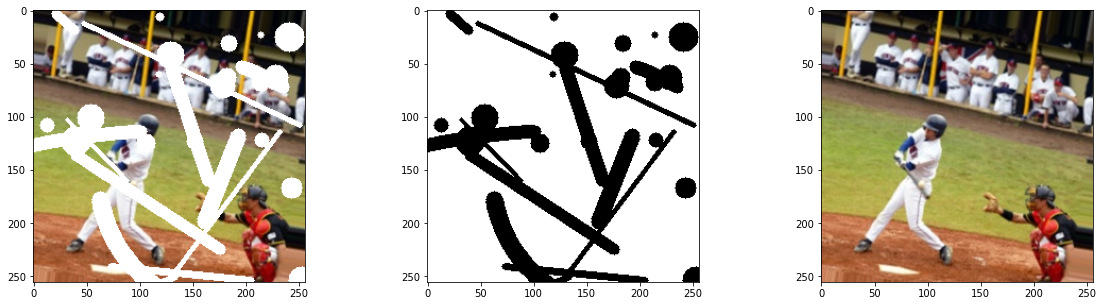

In [5]:
class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=4)

# Get samples & Display them
(masked, mask), ori = next(generator)

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[0,:,:,:])
axes[1].imshow(mask[0,:,:,:]*255)
axes[2].imshow(ori[0,:,:,:])
plt.show()

In [6]:
pred_img_history = []

def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        pred_img_history.append(pred_img[i,:,:,:] * 1.)
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        pred_data = np.array(pred_img[i,:,:,:]*255., dtype=np.uint8)
        ori_data = np.array(ori[i,:,:,:]*255., dtype=np.uint8)
        axes[1].set_title('Predicted Image PSNR:{:.6f}'.format(cv2.PSNR(ori_data, pred_data)))
        axes[2].set_title('Original Image')                
        plt.show()

## Train

In [6]:
history = model.fit(
    generator, 
    steps_per_epoch=1,
    epochs=1,
    plot_callback=plot_callback,
)

Epoch 1/1


In [7]:
## [Resource exhausted, OOM]https://cloud.tencent.com/developer/article/1725483

history = model.fit(
    generator, 
    steps_per_epoch=100,
    epochs=10,
    plot_callback=plot_callback,
)

Epoch 1/1


## Save predict image

True

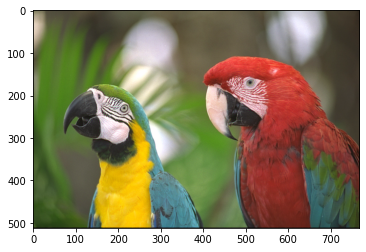

In [ ]:
pred_img = model.predict([masked, mask])
# print("[DEBUG] pred_img", pred_img.shape, pred_img)
rel_pred_img = np.array(pred_img[-1, :, :, :]*255., dtype=np.uint8)
plt.imshow(rel_pred_img)
cv2.imwrite("pred_4(1000).png",  cv2.cvtColor(rel_pred_img, cv2.COLOR_RGB2BGR))

In [ ]:
import imageio
imageio.mimsave('pred_4(1000).gif', pred_img_history)

## PConv inpainting predict for Random Mask

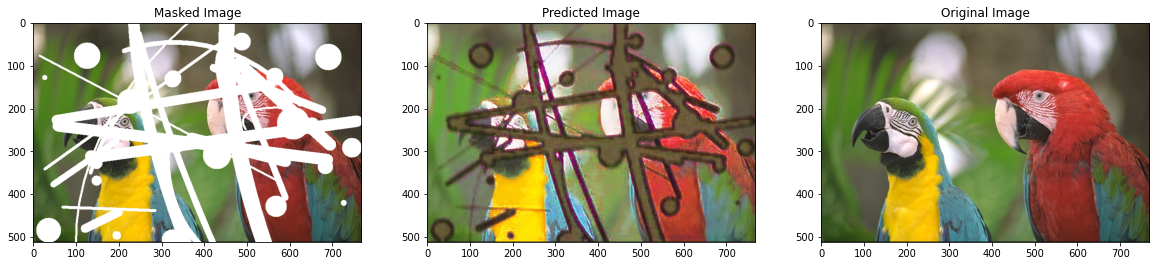

In [ ]:
mask_path = '../pconv/data/data/kodim23_mask.png'

class DataGenerator(ImageDataGenerator):
    def flow(self, x, *args, **kwargs):
        while True:
            
            # Get augmentend image samples
            ori = next(super().flow(x, *args, **kwargs))

            # Get masks for each image sample
            _mask = cv2.imread(mask_path)
            _mask = cv2.cvtColor(_mask, cv2.COLOR_BGR2RGB)
            _mask = cv2.resize(_mask, (image_rows, image_cols)) / 255
            _mask = 1-_mask
            _mask = np.stack([_mask], axis=0)
            mask = _mask
            # print("[DEBUG] _mask", _mask.shape, _mask)
            

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            gc.collect()
            yield [masked, mask], ori        

# Create datagen
datagen = DataGenerator(  
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    horizontal_flip=False
)

# Create generator from numpy arrays
batch = np.stack([img for _ in range(MAX_BATCH_SIZE)], axis=0)
generator = datagen.flow(x=batch, batch_size=1)

# Get samples & Display them
(masked, mask), ori = next(generator)

pred_img = model.predict([masked, mask])

# Show side by side
_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].set_title('Masked Image')
axes[0].imshow(masked[0,:,:,:])
axes[1].set_title('Predicted Image')
axes[1].imshow(pred_img[-1,:,:,:] * 1.)
axes[2].set_title('Original Image')   
axes[2].imshow(ori[0,:,:,:])